In [15]:
!python -V


# from https://nbviewer.jupyter.org/github/napsternxg/pytorch-practice/blob/master/Pytorch%20Uncertainity-animated.ipynb

Python 3.7.4


In [16]:
%matplotlib inline

import numpy as np
import torch
from torch.autograd import Variable

from matplotlib import animation
#Writer = animation.writers['pillow']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

import matplotlib.pyplot as plt


import seaborn as sns
ffmpeg_path = 'C://Users//thoma//Documents//ffmpeg//FFmpeg//bin'#//bin'
#C:\Users\thoma\Documents\ffmpeg\FFmpeg\bin
#plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path

from tqdm import tqdm, trange
from ipywidgets import interact, fixed
from IPython.display import HTML, display
import os

In [17]:
plt.rcParams["figure.figsize"] = (20,10)


In [18]:
os.listdir(ffmpeg_path)

['ffmpeg.exe', 'ffplay.exe', 'ffprobe.exe']

In [19]:
sns.set_context("poster")
sns.set_style("ticks")

np.random.seed(101217209)

In [20]:
def append_x_min(array,xmin,xmax):
    return np.insert(np.insert(array,0,xmin),-1,xmax)

def get_data(N, min_x, max_x):
    w, b = np.random.randn(2)
    def true_model(X):
        lin_factor = w * X + b
        y = np.sin(lin_factor*10)*(lin_factor**2)
        return y
    X_true = np.arange(min_x, max_x, 0.01)
    X_true = append_x_min(X_true,min_x,max_x)
    
    y_true = true_model(X_true)
    span = (max_x - min_x)
    scale = 0.2
    X_obs = min_x + span*scale + np.random.rand(N)*(span - 2*scale*span)
    #X_obs = np.append(np.array([min_x]),[list(X_obs), max_x])
    X_obs = append_x_min(X_obs,min_x,max_x)
    #return X_obs
    y_obs = true_model(X_obs) + np.random.randn(N+2)*0.4
    y_obs[-1] = y_obs[-1]+3

    return (X_obs, y_obs, X_true, y_true), (w, b, true_model)

In [21]:
#x,y = generate_data_()

In [22]:
#plt.plot(x,y)

In [23]:
N = 100
min_x, max_x = -3, 1
(X_obs, y_obs, X_true, y_true), (w, b, true_model) = get_data(N, min_x, max_x)

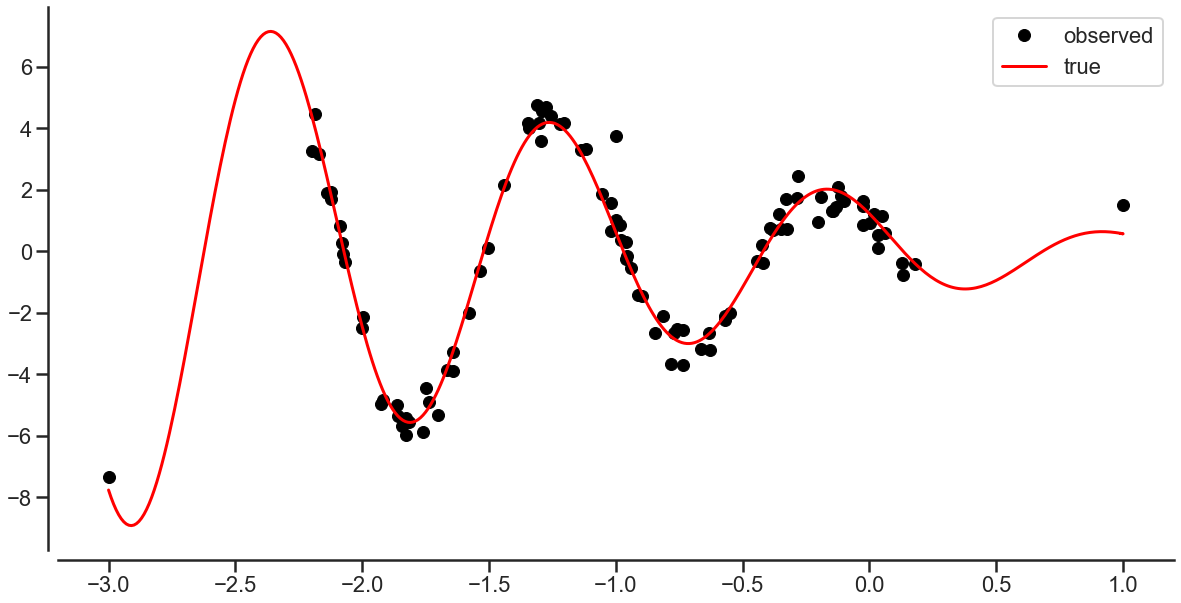

In [24]:
plt.plot(X_obs, y_obs, ls="none", marker="o", color="k", label="observed")
plt.plot(X_true, y_true, ls="-", color="r", label="true")
plt.legend()
sns.despine(offset=10)

In [62]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 10),
            non_linearity(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(10,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)
    
    
class VanillaEnsemble(object):
    def __init__(self, p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None):
        self.models = [SimpleModel(p,decay,non_linearity) for model in range(n_models)]
        self.optimizers = [torch.optim.Adam(
            model.parameters(),
            weight_decay=model.decay) for model in self.models]
        self.criterion = torch.nn.MSELoss()
        self.dropout_p = p
        self.decay = decay
        
    def fit_model(self, model, optimizer, X_obs,y_obs):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = model(X_obs[:, np.newaxis])
        optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        return loss
    
    def shuffle(self,X,y):
        arr = np.arange(len(y))
        np.random.shuffle(arr)
        return X[arr], y[arr]

    
    def fit_ensemble(self, X_abs, y_abs):
        losslist = []
        for model,optimizer in zip(self.models,self.optimizers):
            
            shuffled_X, shuffled_y = self.shuffle(X_abs,y_abs)
            
            losslist.append(self.fit_model(model, optimizer, shuffled_X, shuffled_y))
        return losslist


class BootstrapEnsemble(VanillaEnsemble):
    def __init__(self, p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None, dataset_lenght=None,bootstrap_p_positive=0.7):
        super(BootstrapEnsemble, self).__init__( p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None)
        
        self.dataset_lenght = dataset_lenght
        self.bootstrap_dataset_indices = [np.random.choice(a=[True, False], size=dataset_lenght, p=[bootstrap_p_positive, 1-bootstrap_p_positive]) for model in self.models]


    def fit_ensemble(self, X_abs, y_abs):
        losslist = []
        for model,optimizer,indices in zip(self.models,self.optimizers,self.bootstrap_dataset_indices):
            
            X_bootstrapped, y_bootstrapped = X_abs[indices], y_abs[indices]
            
            shuffled_X, shuffled_y = self.shuffle(X_bootstrapped, y_bootstrapped)
            
            losslist.append(self.fit_model(model, optimizer, shuffled_X, shuffled_y))
        return losslist
    
        
        
        
    
def uncertainity_estimate(X, model, iters, l2=0.005, range_fn=trange):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in range_fn(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1-model.dropout_p) / (2*N*model.decay)
    y_variance += (1/tau)
    y_std = np.sqrt(y_variance) + (1/tau)
    return y_mean, y_std


def ensemble_uncertainity_estimate(X, ensemble, iters, l2=0.005, range_fn=trange):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for model in ensemble.models])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1-ensemble.dropout_p) / (2*N*ensemble.decay)
    y_variance += (1/tau)
    y_std = np.sqrt(y_variance)# + (1/tau)
    return y_mean, y_std



def plot_model(model, iters=200, l2=0.005, n_std=3, ax=None, uncertainty_function=uncertainity_estimate):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,1)
    y_mean, y_std = uncertainty_function(X_true, model, iters, l2=l2)
    
    ax.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
    ax.plot(X_true, y_true, ls="-", color="r", label="true")
    ax.plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax.fill_between(
            X_true,
            y_mean - y_std * ((i+1)/2),
            y_mean + y_std * ((i+1)/2),
            color="b",
            alpha=0.1
        )
    ax.legend()
    sns.despine(offset=10)
    return ax

In [63]:
with np.random.seed(42) as seed:
    np.random.choice(a=[False, True], size=100, p=[0.3, 1-0.3])

AttributeError: __enter__

In [64]:
#model = SimpleModel(p=0.1, decay = 1e-6, non_linearity=torch.nn.ReLU)
ensemble = BootstrapEnsemble(p=0.0, decay = 1e-6, non_linearity=torch.nn.ReLU,dataset_lenght =len(y_obs))

In [65]:
ensemble.bootstrap_dataset_indices

[array([ True, False, False,  True,  True,  True,  True, False,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False, False, False, False,
         True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, False,  True, False, False,  True,
         True, False, False, False, False,  True,  True,  True, False,
         True,  True,  True,  True,  True, False,  True, False,  True,
         True, False, False,  True, False,  True,  True,  True,  True,
         True,  True,  True]),
 array([ True,  True, False,  True,  True, False,  True,  True,  True,
         True, False, False,  True, False, False,  True, False,  True,
        False, False,  True,  True,  True,  Tr

In [66]:
#y_mean, y_std = uncertainity_estimate(X_true, model, 200)
y_mean, y_std = ensemble_uncertainity_estimate(X_true, ensemble, 200)

In [67]:
#y_mean

In [68]:
#criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(
#    model.parameters(),
#    weight_decay=model.decay)

In [69]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:50<00:00, 58.63it/s]


loss=[tensor(0.7100, grad_fn=<MseLossBackward>), tensor(0.6333, grad_fn=<MseLossBackward>), tensor(1.2649, grad_fn=<MseLossBackward>), tensor(1.5242, grad_fn=<MseLossBackward>), tensor(0.6247, grad_fn=<MseLossBackward>), tensor(0.6621, grad_fn=<MseLossBackward>), tensor(0.6509, grad_fn=<MseLossBackward>), tensor(0.6010, grad_fn=<MseLossBackward>), tensor(0.7597, grad_fn=<MseLossBackward>), tensor(0.5875, grad_fn=<MseLossBackward>)]


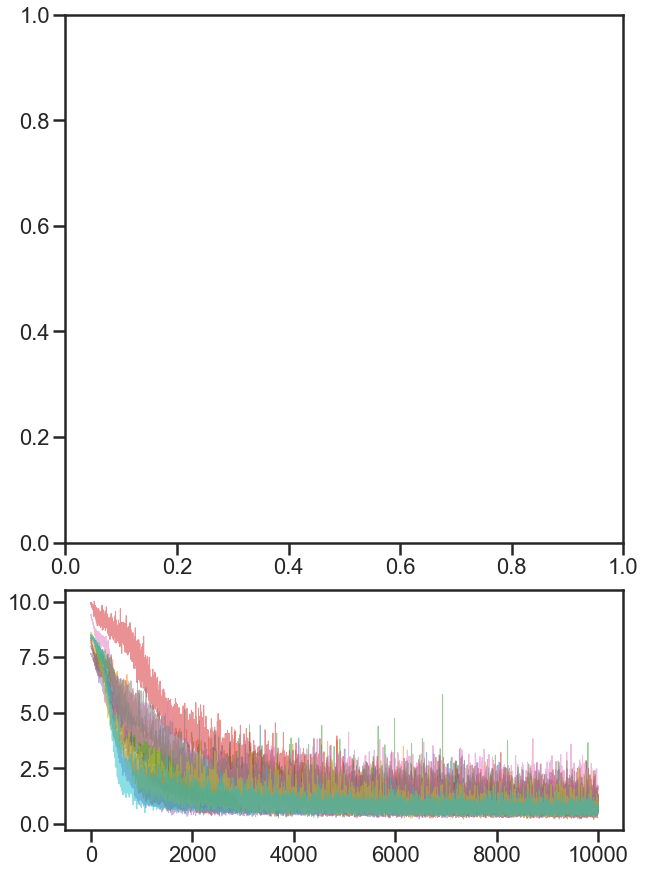

In [70]:
fig = plt.figure(figsize=(10, 15))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(10000):
    loss = ensemble.fit_ensemble(X_obs,y_obs)
    losses.append(loss)
print("loss={}".format(loss))
ax1.plot(losses, ls="-", lw=1, alpha=0.5)
#plot_model(model, l2=0.01, ax=ax0)

<Figure size 1440x720 with 0 Axes>

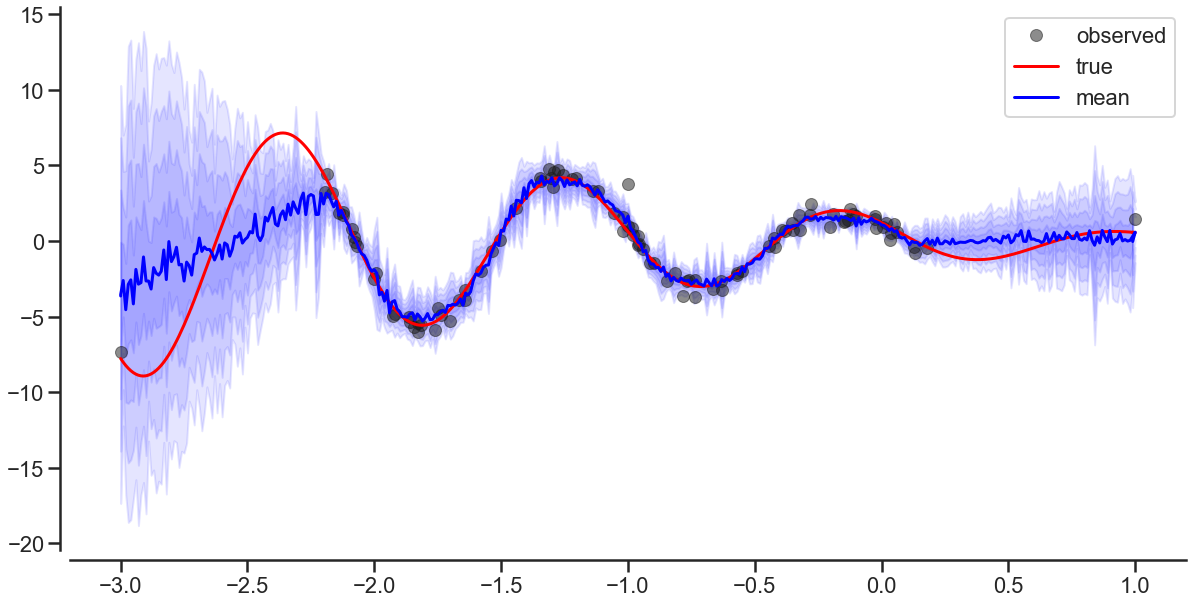

In [71]:
plot_model(ensemble, n_std=4, l2=10, uncertainty_function=ensemble_uncertainity_estimate)


In [72]:
class AnimateBootstrapEnsemble(BootstrapEnsemble):
    def __init__(self,p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None):
        super(AnimateBootstrapEnsemble, self).__init__(p, decay, non_linearity, n_models, model_list,dataset_lenght)

        self.losses = []
        self.n_std = n_std
        self.u_iters = u_iters
        self.l2 = l2
        self.title = title
        
        ## plot items
        self.fig, self.ax0 = plt.subplots(1,1)
        
        self.ax0.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
        self.ax0.plot(X_true, y_true, ls="-", color="r", label="true")
        self.ln_mean, = self.ax0.plot([], [], ls="-", color="b", label="mean")
        
        self.loss_text = self.ax0.set_title('', fontsize=15)
        
        self.fill_stds = []
        for i in range(self.n_std):
            fill_t = self.ax0.fill_between(
                [], [], [],
                color="b",
                alpha=0.5**(i+1)
            )
            self.fill_stds.append(fill_t)
            
        self.ax0.legend(loc="upper left")
        
        
    def init_plot(self):
        self.ln_mean.set_data([], [])
        self.loss_text.set_text('')
        return self.ln_mean, self.loss_text
    
    def animate_plot(self, i,iters=50):
        for j in range(iters):
            loss = self.fit_ensemble(X_obs,y_obs)
            self.losses.append(loss)
        
        #self.loss_text.set_text('{}, loss[{}]={:.3f}'.format(self.title, (i+1)*100, loss))
        
        y_mean, y_std = ensemble_uncertainity_estimate(
            X_true, self, self.u_iters, l2=self.l2,
            range_fn=range
        )
        
        self.ln_mean.set_data(X_true, y_mean)
        for i in range(self.n_std):
            self.fill_stds[i].remove()
            self.fill_stds[i] = self.ax0.fill_between(
                X_true,
                y_mean - y_std * ((i+1)/2),
                y_mean + y_std * ((i+1)/2),
                color="b",
                alpha=0.5**(i+1)
            )
        return [self.ln_mean, self.loss_text] + self.fill_stds
        
        
    def train(self, iters, interval=100):
        anim = animation.FuncAnimation(
            self.fig, self.animate_plot, init_func=self.init_plot,
            frames=range(iters), interval=interval, blit=True)
        return HTML(anim.to_html5_video())

In [73]:
class AnimateTraining(object):
    def __init__(self, model, u_iters=100, l2=1, n_std=4, title=""):
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            model.parameters(),
            weight_decay=model.decay)
        
        self.losses = []
        self.n_std = n_std
        self.u_iters = u_iters
        self.l2 = l2
        self.title = title
        
        ## plot items
        self.fig, self.ax0 = plt.subplots(1,1)
        
        self.ax0.plot(X_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
        self.ax0.plot(X_true, y_true, ls="-", color="r", label="true")
        self.ln_mean, = self.ax0.plot([], [], ls="-", color="b", label="mean")
        
        self.loss_text = self.ax0.set_title('', fontsize=15)
        
        self.fill_stds = []
        for i in range(self.n_std):
            fill_t = self.ax0.fill_between(
                [], [], [],
                color="b",
                alpha=0.5**(i+1)
            )
            self.fill_stds.append(fill_t)
            
        self.ax0.legend(loc="upper left")
        
        
    def fit_model(self):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = self.model(X_obs[:, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss
            
    def init_plot(self):
        self.ln_mean.set_data([], [])
        self.loss_text.set_text('')
        return self.ln_mean, self.loss_text
    
    def animate_plot(self, i,iters=50):
        for j in range(iters):
            loss = self.fit_model().data.numpy()
            self.losses.append(loss)
        
        self.loss_text.set_text('{}, loss[{}]={:.3f}'.format(self.title, (i+1)*100, loss))
        
        y_mean, y_std = uncertainity_estimate(
            X_true, self.model, self.u_iters, l2=self.l2,
            range_fn=range
        )
        
        self.ln_mean.set_data(X_true, y_mean)
        for i in range(self.n_std):
            self.fill_stds[i].remove()
            self.fill_stds[i] = self.ax0.fill_between(
                X_true,
                y_mean - y_std * ((i+1)/2),
                y_mean + y_std * ((i+1)/2),
                color="b",
                alpha=0.5**(i+1)
            )
        return [self.ln_mean, self.loss_text] + self.fill_stds
        
        
    def train(self, iters, interval=100):
        anim = animation.FuncAnimation(
            self.fig, self.animate_plot, init_func=self.init_plot,
            frames=range(iters), interval=interval, blit=True)
        return HTML(anim.to_html5_video())

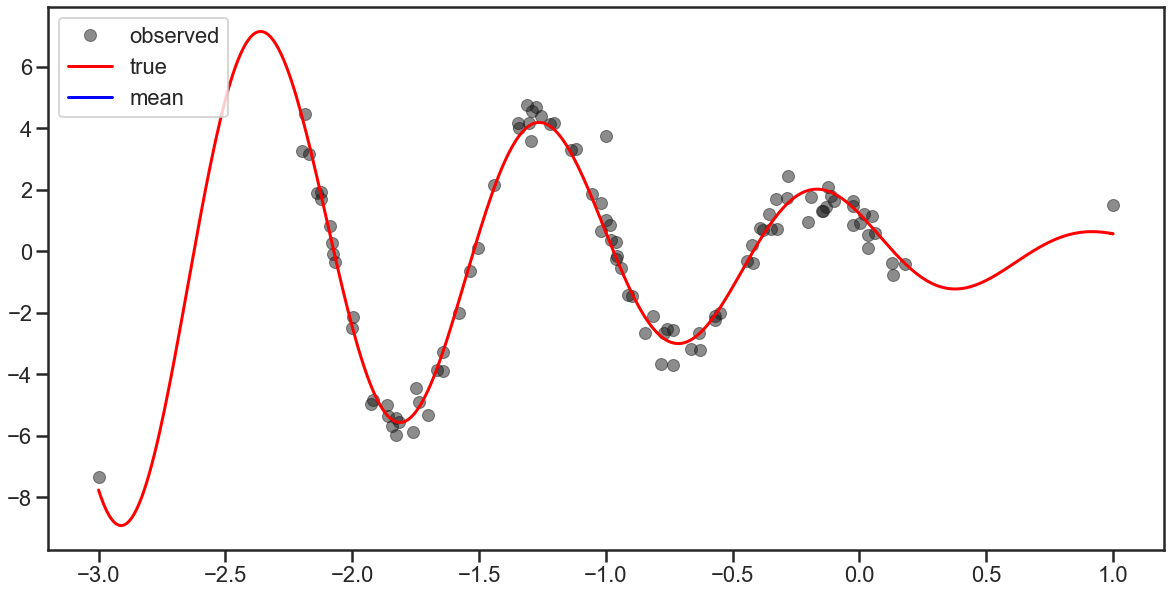

In [74]:
#model = AnimateVanillaEnsemble(p=0.1, decay = 1e-6, non_linearity=torch.nn.LeakyReLU)
animate_obj = AnimateBootstrapEnsemble(p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght =len(y_obs))

In [75]:
animate_obj.train(100, interval=100)


In [76]:
# !pip install ffmpeg

In [77]:
! pip install ffmpeg-python


In [78]:
! pip install Pillow